# Lab Six: Convolutional Neural Networks
##### Sian Xiao & Tingting Zhao

## 0. Dataset Selection

The Chinese MNIST (Chinese numbers handwritten characters images) dataset is downloaded from [Kaggle](https://www.kaggle.com/gpreda/chinese-mnist). It's collected and modified from a [project at Newcastle University](https://data.ncl.ac.uk/articles/dataset/Handwritten_Chinese_Numbers/10280831/1).

In the original project, one hundred Chinese nationals took part in data collection. Each participant wrote with a standard black ink pen all 15 numbers in a table with 15 designated regions drawn on a white A4 paper. This process was repeated 10 times with each participant. Each sheet was scanned at the resolution of 300x300 pixels.
It resulted a dataset of 15000 images, each representing one character from a set of 15 characters (grouped in samples, grouped in suites, with 10 samples/volunteer and 100 volunteers).

The modified dataset (Kaggle) contains the following:
* an index file, chinese_mnist.csv
* a folder with 15,000 jpg images, sized 64 x 64.

The .csv file contains a data frame with following attributes:
* `suite_id`: There are totally 100 suites, each created by a volunteer.
* `sample_id`: Each volunteer created 10 samples.
* `code`: Each sample contains characters from 0 to 100M (totally 15 Chinese number characters). This is a code used to identify.
* `value`: Numerical value of each character.
* `character`:The actual Chinese character corresponding to one number.

The mapping of value, character and code is shown below:

| value     | character | code |
|-----------|-----------|------|
| 0         | 零        | 1    |
| 1         | 一        | 2    |
| 2         | 二        | 3    |
| 3         | 三        | 4    |
| 4         | 四        | 5    |
| 5         | 五        | 6    |
| 6         | 六        | 7    |
| 7         | 七        | 8    |
| 8         | 八        | 9    |
| 9         | 九        | 10   |
| 10        | 十        | 11   |
| 100       | 百        | 12   |
| 1000      | 千        | 13   |
| 10000     | 万        | 14   |
| 100000000 | 亿        | 15   |

The file names are `<suite_id>_<sample_id>_<code>.jpg`.

In [1]:
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import os
import numpy as np
from collections import Counter
import cv2
import warnings

warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from skimage.feature import daisy
from matplotlib import pyplot as plt
import seaborn as sns
from math import ceil
from tensorflow.keras.layers import Add, Input, average, concatenate, Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, SeparableConv2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

%matplotlib inline

## 1. Preparation
### 1.1 Metrics

In [3]:
data = pd.read_csv('data/chinese_mnist.csv', encoding='utf-8')
data_group = data.groupby(by=['code','value'])
data_group.character.value_counts()

code  value      character
1     0          零            1000
2     1          一            1000
3     2          二            1000
4     3          三            1000
5     4          四            1000
6     5          五            1000
7     6          六            1000
8     7          七            1000
9     8          八            1000
10    9          九            1000
11    10         十            1000
12    100        百            1000
13    1000       千            1000
14    10000      万            1000
15    100000000  亿            1000
Name: character, dtype: int64

In [4]:
image_files = list(os.listdir("data/image"))
print(f"Number of image files in folder: {len(image_files)}")
print(f"Number of instances in csv: {len(data)}")

Number of image files in folder: 15000
Number of instances in csv: 15000


**There are metrics designed for unbalanced dataset (like Cohen’s Kappa). Also, we can use precision, recall and F1 score (mainly for binary classification, or one-to-rest classification). As the dataset itself is well-organized to be balanced, and we care each category equaily, we don't need to use those complicated metrics designed for unbalanced dataset. If we have a cancer recgnition task, we need to care about false negative rate. But here we just need a high accuracy for all numbers. So we use accuracy as evaluation metrics.**

**Confusion matrix can be used to visualize the result.**

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

`from sklearn.metrics import multilabel_confusion_matrix, log_loss, f1_score, accuracy_score, precision_score, recall_score`

### 1.2 Splits


In [5]:
%%time

X_list, y_list = [], []
for file in image_files:
    code = int(file.split('.jpg')[0].split('_')[-1])
    img_path = 'data/image/' + file
    img = cv2.imread(img_path, 0)  # Load image in grayscale mode
    img_re = cv2.bitwise_not(img)
    img_new = img_re/255.0 -0.5  # Zero mean
    X_list.append(img_new)
    y_list.append(code-1)  # Zero base to use keras.utils.to_categorical

X_ori = np.array(X_list)
y_ori = np.array(y_list)

### !!!Note!!!
### From here, code-1 is the index for value now!!!

CPU times: user 2.25 s, sys: 2.13 s, total: 4.38 s
Wall time: 20.7 s


| value     | 0  | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 100 | 1E3 | 1E4 | 1E8 |
|-----------|----|----|----|----|----|----|----|----|----|----|----|-----|-----|-----|-----|
| code      | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12  | 13  | 14  | 15  |
| character | 零 | 一 | 二 | 三 | 四 | 五 | 六 | 七 | 八 | 九 | 十 | 百  | 千  | 万  | 亿  |
| y         | 0  | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11  | 12  | 13  | 14  |

In [6]:
NUM_CLASSES = 15
img_wh = 64
X = np.expand_dims(X_ori.reshape((-1,img_wh,img_wh)), axis=3)
print(X[0].shape)
y = keras.utils.to_categorical(y_ori, NUM_CLASSES)
print(y[:10])

(64, 64, 1)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


**We choose to use Stratified K-Folds cross-validator because it can preserve the percentage of samples for each class. As we hope to classify different characters, we should learn from each classification equally.**

In [7]:
skf = StratifiedKFold(n_splits=4)
train_idx_list, test_idx_list = [], []

# have to use y_ori ('multiclass') to use StratifiedKFold
# can't use y, but index is universal for y and y_ori

for train_idx, test_idx in skf.split(X, y_ori):
    train_idx_list.append(train_idx)
    test_idx_list.append(test_idx)

In [8]:
for i in range(4):
    fold = list(y_ori[train_idx_list[0]])
    print(Counter(fold))

Counter({11: 750, 14: 750, 9: 750, 13: 750, 7: 750, 10: 750, 12: 750, 8: 750, 2: 750, 3: 750, 5: 750, 4: 750, 0: 750, 6: 750, 1: 750})
Counter({11: 750, 14: 750, 9: 750, 13: 750, 7: 750, 10: 750, 12: 750, 8: 750, 2: 750, 3: 750, 5: 750, 4: 750, 0: 750, 6: 750, 1: 750})
Counter({11: 750, 14: 750, 9: 750, 13: 750, 7: 750, 10: 750, 12: 750, 8: 750, 2: 750, 3: 750, 5: 750, 4: 750, 0: 750, 6: 750, 1: 750})
Counter({11: 750, 14: 750, 9: 750, 13: 750, 7: 750, 10: 750, 12: 750, 8: 750, 2: 750, 3: 750, 5: 750, 4: 750, 0: 750, 6: 750, 1: 750})


**It's perfectly balanced.**

## 2. Modeling

### 2.1 Data expansion

**Since in realality the character may be captured in different direaction, distorted, so we turn on rotation, width_shift, height_shift,zoom functions. Because flipping a character will not confuse the character with another, so flipping is meaningless in this case.**

**Let's use the first fold as example.**

In [9]:
X_train, X_test = X[train_idx_list[0]], X[test_idx_list[0]]
y_train, y_test = y[train_idx_list[0]], y[test_idx_list[0]]  # note here we have to use one hot encoded y

In [10]:
%%time

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,  # people would write characters slightly different in direction
    width_shift_range=4,  # same as 0.046875, allow move within 4 pixels.
    height_shift_range=4,  # same as 0.046875, allow move within 4 pixels.
    shear_range=0.,  # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.03,  # different people write characters of different sizes
    channel_shift_range=0.,
    fill_mode='nearest',  # I think it's the same to use 'constant' since edges of picture are 1.0
    cval=1.,
    horizontal_flip=False,  # flip a character is meaningless in our case
    vertical_flip=False,  # flip a character is meaningless in our case
    rescale=None)

datagen.fit(X_train)

CPU times: user 43.1 ms, sys: 126 ms, total: 169 ms
Wall time: 167 ms


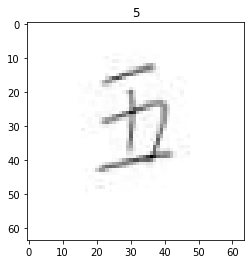

In [11]:
tmps = datagen.flow(X_train, y_train, batch_size=1)
labels = ["零","一","二","三","四","五","六","七","八","九","十","百","千","万","亿"]
for tmp in tmps:
    plt.imshow(tmp[0].squeeze(), cmap=plt.cm.gray)
    plt.title(np.argmax(tmp[1]))  # didn't install Chinese font in my matplotlib, can't use labels[].
    break

### 2.2 CNN architectures
**Here we used AlexNet (Alex), ResNet and Ensemble Nets (EnsNet) architectures, each architecture we enhanced the number of filter by 8 times and add one more layer of the fully connected MLP.**

#### 2.2.1 AlexNet
**Alex_1**

In [12]:
### AlexNet style convolutional phase ###

Alex_1 = Sequential(name='Alex_1')

Alex_1.add(Conv2D(filters=8, input_shape = (img_wh,img_wh,1),kernel_size=(3,3), 
                  padding='same', activation='relu', data_format="channels_last"))
Alex_1.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
Alex_1.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))


Alex_1.add(Dropout(0.25))
Alex_1.add(Flatten())
Alex_1.add(Dense(128, activation='relu'))
Alex_1.add(Dropout(0.5))
Alex_1.add(Dense(NUM_CLASSES, activation='softmax'))

Alex_1.compile(loss='categorical_crossentropy',  # 'categorical_crossentropy' 'mean_squared_error'
               optimizer='rmsprop',  # 'adadelta' 'rmsprop'
               metrics=['accuracy']
              )
Alex_1.summary()

Model: "Alex_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0    

2021-11-29 16:04:29.574150: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
%%time
# the flow method yields batches of images indefinitely, with the given transformations
history_Alex_1 = Alex_1.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                      steps_per_epoch=int(len(X_train)/64),
                                      epochs=30, verbose=1,
                                      validation_data=(X_test,y_test),
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                     )

Epoch 1/30


2021-11-29 16:04:29.779827: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-29 16:04:29.780350: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100135000 Hz


175/175 [==============================] - 8s 42ms/step - loss: 2.6845 - accuracy: 0.1142 - val_loss: 2.0104 - val_accuracy: 0.4029
Epoch 2/30
175/175 [==============================] - 7s 39ms/step - loss: 2.1645 - accuracy: 0.3000 - val_loss: 1.5218 - val_accuracy: 0.5909
Epoch 3/30
175/175 [==============================] - 7s 38ms/step - loss: 1.7747 - accuracy: 0.4192 - val_loss: 1.2193 - val_accuracy: 0.6491
Epoch 4/30
175/175 [==============================] - 7s 38ms/step - loss: 1.5019 - accuracy: 0.4999 - val_loss: 1.0037 - val_accuracy: 0.6997
Epoch 5/30
175/175 [==============================] - 7s 38ms/step - loss: 1.2817 - accuracy: 0.5700 - val_loss: 0.7566 - val_accuracy: 0.7656
Epoch 6/30
175/175 [==============================] - 7s 39ms/step - loss: 1.1599 - accuracy: 0.6092 - val_loss: 0.6546 - val_accuracy: 0.8011
Epoch 7/30
175/175 [==============================] - 7s 39ms/step - loss: 1.0693 - accuracy: 0.6421 - val_loss: 0.6221 - val_accuracy: 0.7912
Epoch 8/30

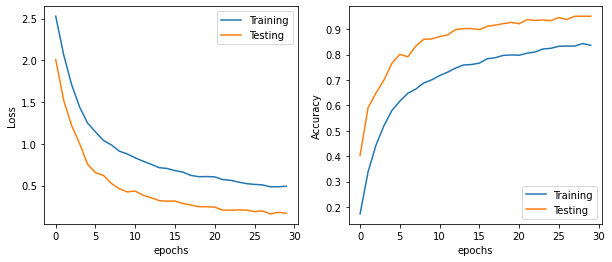

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_Alex_1.history['loss'],label='Training')
plt.plot(history_Alex_1.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_Alex_1.history['accuracy'],label='Training')
plt.plot(history_Alex_1.history['val_accuracy'],label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

**Alex_2**

In [15]:
### AlexNet style convolutional phase ###

Alex_2 = Sequential(name='Alex_2')

Alex_2.add(Conv2D(filters=64, input_shape = (img_wh,img_wh,1),kernel_size=(3,3), 
                  padding='same', activation='relu', data_format="channels_last"))
Alex_2.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
Alex_2.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))
    

# add one layer on flattened output
Alex_2.add(Dropout(0.20))
Alex_2.add(Flatten())
Alex_2.add(Dense(128, activation='relu'))
Alex_2.add(Dropout(0.40))
Alex_2.add(Dense(64, activation='relu'))
Alex_2.add(Dropout(0.60))
Alex_2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
Alex_2.compile(loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics=['accuracy']
               )
Alex_2.summary()

Model: "Alex_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0    

In [16]:
%%time

history_Alex_2 = Alex_2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                      steps_per_epoch=int(len(X_train)/64),
                                      epochs=30, verbose=1,
                                      validation_data=(X_test,y_test),
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                     )

Epoch 1/30
175/175 [==============================] - 53s 301ms/step - loss: 3.0907 - accuracy: 0.0846 - val_loss: 2.1054 - val_accuracy: 0.4416
Epoch 2/30
175/175 [==============================] - 52s 295ms/step - loss: 2.2456 - accuracy: 0.2774 - val_loss: 1.1855 - val_accuracy: 0.6960
Epoch 3/30
175/175 [==============================] - 52s 299ms/step - loss: 1.6529 - accuracy: 0.4439 - val_loss: 0.7500 - val_accuracy: 0.7549
Epoch 4/30
175/175 [==============================] - 52s 297ms/step - loss: 1.3841 - accuracy: 0.5341 - val_loss: 0.6885 - val_accuracy: 0.7645
Epoch 5/30
175/175 [==============================] - 52s 297ms/step - loss: 1.1101 - accuracy: 0.6200 - val_loss: 0.5104 - val_accuracy: 0.8373
Epoch 6/30
175/175 [==============================] - 52s 299ms/step - loss: 0.9665 - accuracy: 0.6607 - val_loss: 0.4634 - val_accuracy: 0.8427
Epoch 7/30
175/175 [==============================] - 52s 298ms/step - loss: 0.8963 - accuracy: 0.6981 - val_loss: 0.3460 - val_ac

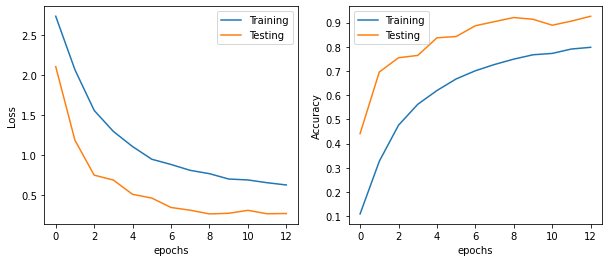

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_Alex_2.history['loss'],label='Training')
plt.plot(history_Alex_2.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_Alex_2.history['accuracy'],label='Training')
plt.plot(history_Alex_2.history['val_accuracy'],label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

#### 2.2.2 ResNet
**ResNet_1**

In [18]:
### ResNet-Style Bypass ###

l2_lambda= 0.000001
input_holder = Input(shape=(img_wh, img_wh, 1))

x = Conv2D(filters=8, input_shape = (img_wh,img_wh,1), kernel_size=(3,3),
           kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda),
           padding='same', activation='relu', data_format="channels_last")(input_holder)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)
x = Conv2D(filters=8, kernel_size=(3,3), kernel_initializer='he_uniform', 
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Conv2D(filters=16, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same', activation='relu', 
           data_format="channels_last")(x_split)
x = Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)
x = Conv2D(filters=8, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)


x = Add()([x, x_split])
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

ResNet_1 = Model(inputs=input_holder, outputs=x, name='ResNet_1')
ResNet_1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
ResNet_1.summary()

Model: "ResNet_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 8)    584         max_pooling2d_2[0][0]            
___________________________________________________________________________________________

In [19]:
%%time

history_ResNet_1 = ResNet_1.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1,
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 7s 38ms/step - loss: 2.5456 - accuracy: 0.1576 - val_loss: 1.5828 - val_accuracy: 0.5275
Epoch 2/30
175/175 [==============================] - 7s 37ms/step - loss: 1.7367 - accuracy: 0.4452 - val_loss: 0.9807 - val_accuracy: 0.7171
Epoch 3/30
175/175 [==============================] - 6s 37ms/step - loss: 1.2575 - accuracy: 0.5733 - val_loss: 0.7885 - val_accuracy: 0.7309
Epoch 4/30
175/175 [==============================] - 6s 36ms/step - loss: 0.9856 - accuracy: 0.6538 - val_loss: 0.5197 - val_accuracy: 0.8424
Epoch 5/30
175/175 [==============================] - 6s 37ms/step - loss: 0.8319 - accuracy: 0.7101 - val_loss: 0.4085 - val_accuracy: 0.8819
Epoch 6/30
175/175 [==============================] - 6s 37ms/step - loss: 0.7102 - accuracy: 0.7490 - val_loss: 0.3720 - val_accuracy: 0.8811
Epoch 7/30
175/175 [==============================] - 6s 37ms/step - loss: 0.6368 - accuracy: 0.7766 - val_loss: 0.3328 - val_accuracy: 0.8944

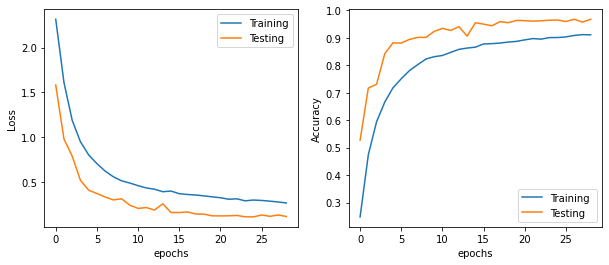

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ResNet_1.history['loss'],label='Training')
plt.plot(history_ResNet_1.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ResNet_1.history['accuracy'],label='Training ')
plt.plot(history_ResNet_1.history['val_accuracy'],label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

**ResNet_2**

In [21]:
%%time

input_holder = Input(shape=(img_wh, img_wh, 1))

x = Conv2D(filters=64, input_shape = (img_wh,img_wh,1), kernel_size=(3,3),
           kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda),
           padding='same', activation='relu', data_format="channels_last")(input_holder)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)
x = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', 
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Conv2D(filters=128, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same', activation='relu', 
           data_format="channels_last")(x_split)
x = Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)
x = Conv2D(filters=64, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)


x = Add()([x, x_split])
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.20)(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation("relu")(x)
x  = Dropout(0.40)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x  = Dropout(0.60)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)


ResNet_2 = Model(inputs=input_holder, outputs=x, name='ResNet_2')
ResNet_2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
ResNet_2.summary()

Model: "ResNet_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 64)   36928       max_pooling2d_5[0][0]            
___________________________________________________________________________________________

In [22]:
%%time

history_ResNet_2 = ResNet_2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1,
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 14s 76ms/step - loss: 2.7499 - accuracy: 0.1274 - val_loss: 0.9139 - val_accuracy: 0.7200
Epoch 2/30
175/175 [==============================] - 13s 75ms/step - loss: 1.1399 - accuracy: 0.6056 - val_loss: 0.4178 - val_accuracy: 0.8613
Epoch 3/30
175/175 [==============================] - 13s 74ms/step - loss: 0.5733 - accuracy: 0.7985 - val_loss: 0.1269 - val_accuracy: 0.9563
Epoch 4/30
175/175 [==============================] - 13s 75ms/step - loss: 0.3564 - accuracy: 0.8815 - val_loss: 0.0898 - val_accuracy: 0.9733
Epoch 5/30
175/175 [==============================] - 13s 74ms/step - loss: 0.2641 - accuracy: 0.9184 - val_loss: 0.1151 - val_accuracy: 0.9643
Epoch 6/30
175/175 [==============================] - 13s 75ms/step - loss: 0.2254 - accuracy: 0.9282 - val_loss: 0.1184 - val_accuracy: 0.9616
Epoch 7/30
175/175 [==============================] - 13s 75ms/step - loss: 0.1673 - accuracy: 0.9508 - val_loss: 0.0533 - val_accuracy:

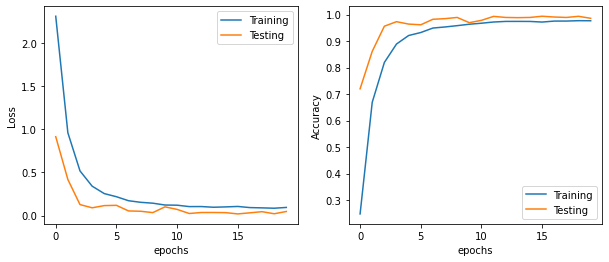

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ResNet_2.history['loss'],label='Training')
plt.plot(history_ResNet_2.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ResNet_2.history['accuracy'],label='Training')
plt.plot(history_ResNet_2.history['val_accuracy'],label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

#### 2.2.3 EnsNet
**EnsNet_1**

In [24]:
### Ensemble Nets ###

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=16,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=16,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=16,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=16,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.25)(x) # add some dropout for regularization after conv layers
    x = Dense(32, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

EnsNet_1 = Model(inputs=input_holder, outputs=x, name='EnsNet_1')
EnsNet_1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
EnsNet_1.summary()

Model: "EnsNet_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 16)   2320        conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_15[0][0]                  
___________________________________________________________________________________________

In [25]:
%%time

history_EnsNet_1 = EnsNet_1.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1, validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 10s 47ms/step - loss: 2.4664 - accuracy: 0.1957 - val_loss: 0.8767 - val_accuracy: 0.7061
Epoch 2/30
175/175 [==============================] - 8s 45ms/step - loss: 0.7829 - accuracy: 0.7383 - val_loss: 0.3417 - val_accuracy: 0.8856
Epoch 3/30
175/175 [==============================] - 8s 45ms/step - loss: 0.4398 - accuracy: 0.8501 - val_loss: 0.1968 - val_accuracy: 0.9352
Epoch 4/30
175/175 [==============================] - 8s 45ms/step - loss: 0.2849 - accuracy: 0.9059 - val_loss: 0.1566 - val_accuracy: 0.9459
Epoch 5/30
175/175 [==============================] - 8s 45ms/step - loss: 0.2350 - accuracy: 0.9224 - val_loss: 0.0953 - val_accuracy: 0.9715
Epoch 6/30
175/175 [==============================] - 8s 46ms/step - loss: 0.1796 - accuracy: 0.9426 - val_loss: 0.0968 - val_accuracy: 0.9667
Epoch 7/30
175/175 [==============================] - 8s 45ms/step - loss: 0.1530 - accuracy: 0.9516 - val_loss: 0.0819 - val_accuracy: 0.973

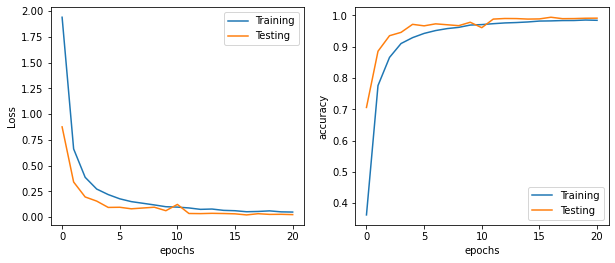

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_EnsNet_1.history['loss'],label='Training')
plt.plot(history_EnsNet_1.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_EnsNet_1.history['accuracy'],label='Training')
plt.plot(history_EnsNet_1.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

**EnsNet_2**

In [27]:
### Ensemble Nets ###

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

x = Conv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):

    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=128,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=128,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    x = Dropout(0.50)(x)
    x = Dense(64,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    branches.append(x)

x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

EnsNet_2 = Model(inputs=input_holder, outputs=x, name='EnsNet_2')
EnsNet_2.compile(loss='categorical_crossentropy',
                 optimizer='rmsprop',
                 metrics=['accuracy']
                )
EnsNet_2.summary()

Model: "EnsNet_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 64, 64, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 32, 32, 64)   0           conv2d_29[0][0]                  
___________________________________________________________________________________________

In [28]:
%%time

history_EnsNet_2 = EnsNet_2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1, validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 53s 291ms/step - loss: 8.0738 - accuracy: 0.0907 - val_loss: 1.4451 - val_accuracy: 0.5547
Epoch 2/30
175/175 [==============================] - 50s 287ms/step - loss: 1.5897 - accuracy: 0.4863 - val_loss: 0.4436 - val_accuracy: 0.8584
Epoch 3/30
175/175 [==============================] - 51s 289ms/step - loss: 0.7344 - accuracy: 0.7710 - val_loss: 0.2025 - val_accuracy: 0.9341
Epoch 4/30
175/175 [==============================] - 50s 287ms/step - loss: 0.4029 - accuracy: 0.8712 - val_loss: 0.1047 - val_accuracy: 0.9659
Epoch 5/30
175/175 [==============================] - 50s 287ms/step - loss: 0.2850 - accuracy: 0.9080 - val_loss: 0.0714 - val_accuracy: 0.9800
Epoch 6/30
175/175 [==============================] - 50s 289ms/step - loss: 0.2606 - accuracy: 0.9267 - val_loss: 0.0671 - val_accuracy: 0.9805
Epoch 7/30
175/175 [==============================] - 51s 290ms/step - loss: 0.1948 - accuracy: 0.9400 - val_loss: 0.0519 - val_ac

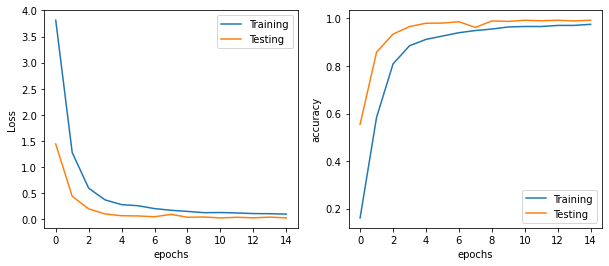

In [29]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_EnsNet_2.history['loss'],label='Training')
plt.plot(history_EnsNet_2.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_EnsNet_2.history['accuracy'],label='Training')
plt.plot(history_EnsNet_2.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

### 2.3 Visualization and Comparison
### 2.3.1 Visualization

In [30]:
# visualize

def visualize_models(X_test, y_test, model_names=[], labels='auto'):
    
    assert isinstance(model_names, list)
    assert all(isinstance(name, str) for name in model_names)
    assert isinstance(y_test[0], np.int64)
    
    height = ceil(len(model_names)/2)
    
    plt.figure(figsize=(20, 6*height))
    
    for i, name in enumerate(model_names):
        model = eval(name)
        yhat_model = np.argmax(model.predict(X_test), axis=1)
        acc_model = mt.accuracy_score(y_test,yhat_model)
        plt.subplot(height,2,i+1)
        cm = mt.confusion_matrix(y_test,yhat_model)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels,
                    cmap = sns.color_palette("YlOrBr", as_cmap=True))
        plt.title(f'{str(name)}: {acc_model}', fontsize=20)
    plt.tight_layout()

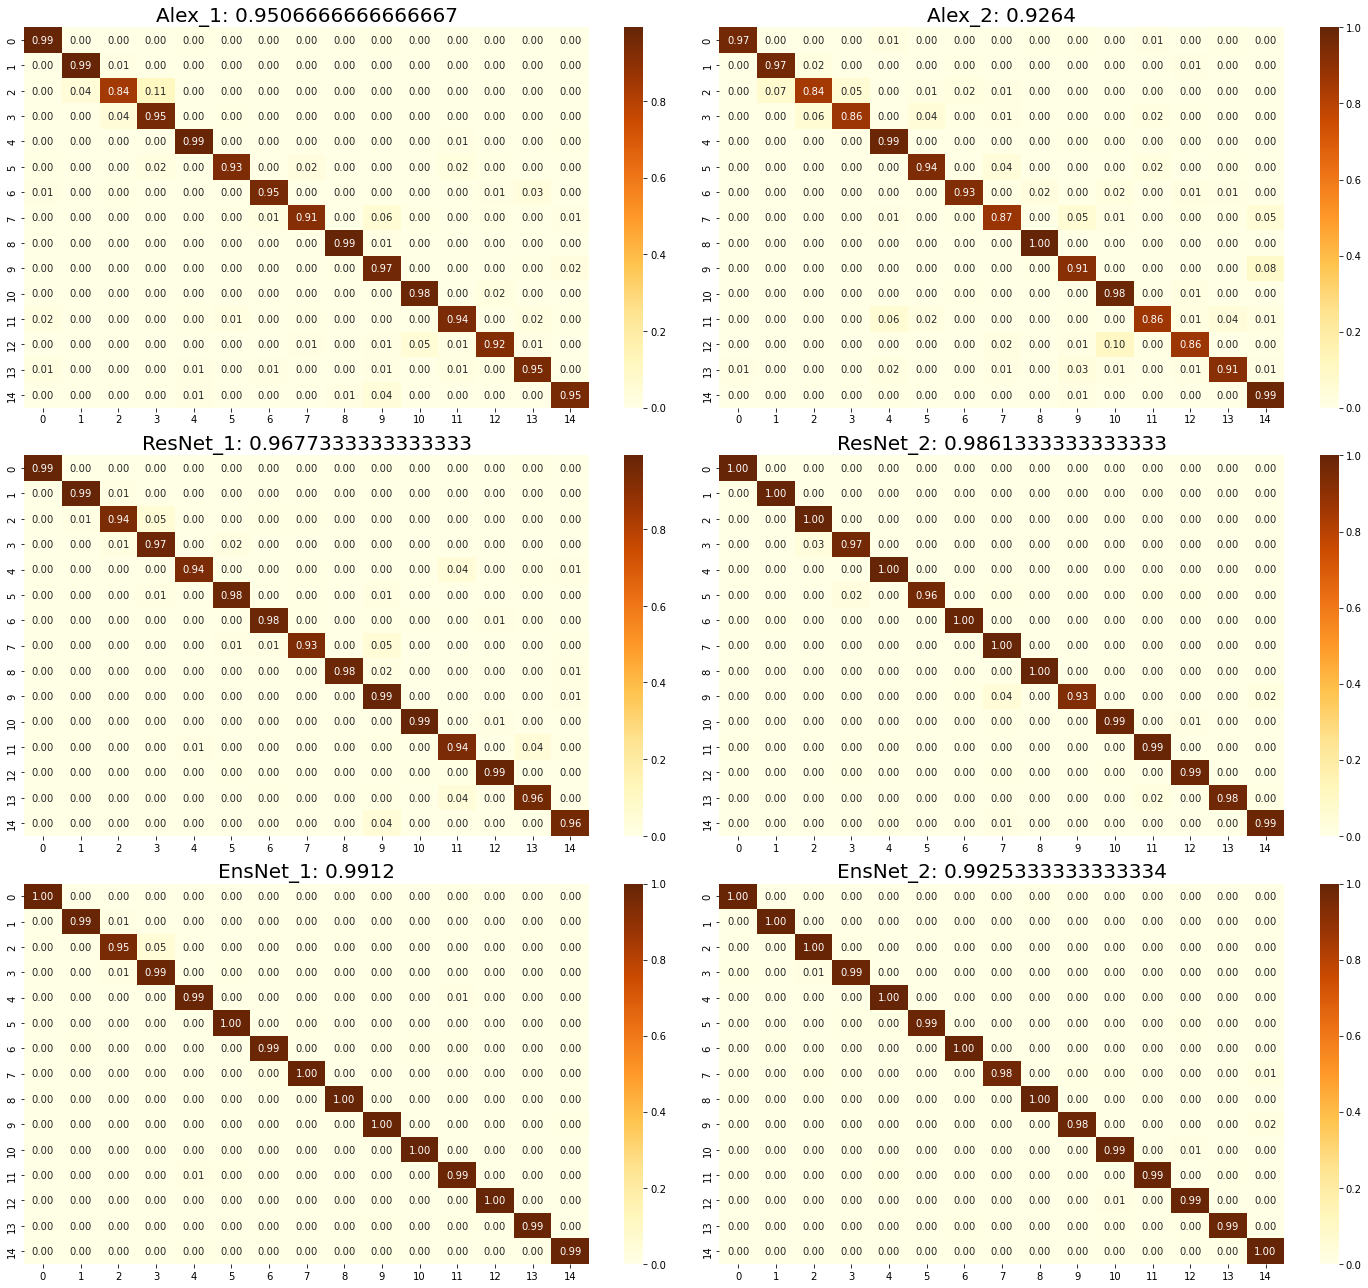

In [31]:
# have to use y_ori since it's 'multiclass' instead of onehot encoded array
visualize_models(X_test, y_ori[test_idx_list[0]], labels='auto',
                 model_names=['Alex_1', 'Alex_2', 'ResNet_1', 'ResNet_2', 'EnsNet_1', 'EnsNet_2'])

**As we can see, it seems EnsNet is better than ResNet, Alex got relatively the worsest results. Let's use statistical method to do the comparison.**

### 2.3.2 Comparison

In [32]:
# Define a function for McNemar's Test
# confidence:           0.90  0.95  0.99
# 1DOF critical value: 2.706 3.841 6.635

def mn_test(ypred1, ypred2, ytrue):
    tab_b = sum((ypred1 == ytrue) & (ypred2 != ytrue))
    tab_c = sum((ypred1 != ytrue) & (ypred2 == ytrue))

    if tab_b + tab_c == 0:
        chi2 = 0
    else:
        chi2 = (abs(tab_b - tab_c)-1)**2 / (tab_b + tab_c)
    
    return round(chi2,4)

**we would like to compare between same architecture with different parameters.**

In [33]:
yhat_Alex_1 = np.argmax(Alex_1.predict(X_test), axis=1)
yhat_Alex_2 = np.argmax(Alex_2.predict(X_test), axis=1)
yhat_ResNet_1 = np.argmax(ResNet_1.predict(X_test), axis=1)
yhat_ResNet_2 = np.argmax(ResNet_2.predict(X_test), axis=1)
yhat_EnsNet_1 = np.argmax(EnsNet_1.predict(X_test), axis=1)
yhat_EnsNet_2 = np.argmax(EnsNet_2.predict(X_test), axis=1)

In [34]:
print("Alex 1 vs Alex 2: Test statistic",mn_test(yhat_Alex_1, yhat_Alex_2, y_ori[test_idx_list[0]]))
print("ResNet 1 vs ResNet 2: Test statistic",mn_test(yhat_ResNet_1, yhat_ResNet_2, y_ori[test_idx_list[0]]))
print("EnsNet 1 vs EnsNet 2: Test statistic",mn_test(yhat_EnsNet_1, yhat_EnsNet_2, y_ori[test_idx_list[0]]))

Alex 1 vs Alex 2: Test statistic 32.7935
ResNet 1 vs ResNet 2: Test statistic 30.2222
EnsNet 1 vs EnsNet 2: Test statistic 0.3556


**As we can see, `ResNet_2` and `Alex_2` are different from `ResNet_1` and `Alex_1`, respectively. While `ResNet_2` and `Alex_1` have higher accuracy, we would say they have better perfromance.**

**We can't conclude `EnsNet_2` is actually better than `EnsNet_1` since the $\chi^2$ value is smaller than 2.706, but it has better accuracy so let's just use `EnsNet_2` as an example.**

**Let's compare `Alex_1` , `ResNet_2` and `EnsNet_2`.**

In [35]:
print("ResNet 2 vs EnsNet 2: Test statistic",mn_test(yhat_ResNet_2, yhat_EnsNet_2, y_ori[test_idx_list[0]]))
print("Alex 1 vs EnsNet 2: Test statistic",mn_test(yhat_Alex_1, yhat_EnsNet_2, y_ori[test_idx_list[0]]))
print("Alex 1 vs ResNet 2: Test statistic",mn_test(yhat_Alex_1, yhat_ResNet_2, y_ori[test_idx_list[0]]))

ResNet 2 vs EnsNet 2: Test statistic 9.4464
Alex 1 vs EnsNet 2: Test statistic 134.453
Alex 1 vs ResNet 2: Test statistic 90.2798


**$\chi^2$ values for all three comparisons much larger than 6.635, so we can say they are different by 99% confidence. And EnsNet_2 actually has the highest accuracy, let's assume EnsNet_2 is the best.**

### 2.4 CNN vs. MLP
**Let's first implement a MLP. Here we tried to use raw data, PCA reduced data, Daisy extraction data to build MLP model.**
#### 2.4.1 Raw data

In [36]:
# Raw data
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=X_train.shape[1], units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )
mlp.compile(loss='mean_squared_error',
            optimizer='rmsprop',
            metrics=['accuracy'])
history_MLP = mlp.fit(X_train, y_train, batch_size=64,
                      epochs=50, verbose=1, validation_data=(X_test,y_test),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
176/176 [==============================] - 1s 3ms/step - loss: 0.0630 - accuracy: 0.0669 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0637 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0630 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0675 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 5/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0605 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 6/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0643 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 7/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0656 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 

**Using raw data as input, the accuracy is terriable**
#### 2.4.2 PCA reduced data

In [37]:
# PCA

n_components = 750
pca= PCA(n_components=n_components).fit(X_train.reshape(X_train.shape[0],-1))
X_train_pca =pca.transform(X_train.reshape(X_train.shape[0],-1))
X_test_pca =pca.transform(X_test.reshape(X_test.shape[0],-1))

In [38]:
mlp_pca = Sequential()
mlp_pca.add( Flatten() )
mlp_pca.add( Dense(input_dim=X_train_pca.shape[1], units=30, 
               activation='relu') )
mlp_pca.add( Dense(units=15, activation='relu') )
mlp_pca.add( Dense(NUM_CLASSES) )
mlp_pca.add( Activation('softmax') )
mlp_pca.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=['accuracy'])
history_MLP_pca = mlp_pca.fit(X_train_pca, y_train, batch_size=64,
                              epochs=150, verbose=1, validation_data=(X_test_pca,y_test),
                              callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                             )

Epoch 1/150
176/176 [==============================] - 1s 2ms/step - loss: 0.0617 - accuracy: 0.0984 - val_loss: 0.0593 - val_accuracy: 0.1712
Epoch 2/150
176/176 [==============================] - 0s 2ms/step - loss: 0.0577 - accuracy: 0.2102 - val_loss: 0.0557 - val_accuracy: 0.2885
Epoch 3/150
176/176 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.3403 - val_loss: 0.0511 - val_accuracy: 0.3979
Epoch 4/150
176/176 [==============================] - 0s 2ms/step - loss: 0.0474 - accuracy: 0.4544 - val_loss: 0.0470 - val_accuracy: 0.4456
Epoch 5/150
176/176 [==============================] - 0s 2ms/step - loss: 0.0431 - accuracy: 0.5037 - val_loss: 0.0447 - val_accuracy: 0.4752
Epoch 6/150
176/176 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.5493 - val_loss: 0.0431 - val_accuracy: 0.5011
Epoch 7/150
176/176 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.5914 - val_loss: 0.0420 - val_accuracy: 0.5131

**From lab2, we knew using the first 750 of components is enough to represent the data, so here we used the first 750 components as input, and the accuracy was enhanced greatly. Let's try using Daisy.**
#### 2.4.3 Daisy extraction data

In [39]:
# daisy

def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=5, radius=5,
                 rings=2, histograms=8, orientations=8,
                 visualize=False)
    return feat.reshape((-1))
X_train_daisy = np.apply_along_axis(apply_daisy, 1, X_train.reshape(-1,64*64),(64,64))
print(X_train_daisy.shape)
X_test_daisy = np.apply_along_axis(apply_daisy, 1, X_test.reshape(-1,64*64),(64,64))
print(X_test_daisy.shape)

(11250, 16456)
(3750, 16456)


In [40]:
mlp_daisy = Sequential()
mlp_daisy.add( Flatten() )
mlp_daisy.add( Dense(input_dim=X_train_daisy.shape[1], units=30, 
               activation='relu') )
mlp_daisy.add( Dense(units=15, activation='relu') )
mlp_daisy.add( Dense(NUM_CLASSES) )
mlp_daisy.add( Activation('softmax') )

mlp_daisy.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

history_MLP_daisy= mlp_daisy.fit(X_train_daisy, y_train, batch_size=64,
                                 epochs=150, verbose=1, validation_data=(X_test_daisy,y_test),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                )

Epoch 1/150
176/176 [==============================] - 1s 5ms/step - loss: 0.0580 - accuracy: 0.2323 - val_loss: 0.0461 - val_accuracy: 0.4573
Epoch 2/150
176/176 [==============================] - 1s 3ms/step - loss: 0.0433 - accuracy: 0.5178 - val_loss: 0.0361 - val_accuracy: 0.6229
Epoch 3/150
176/176 [==============================] - 1s 3ms/step - loss: 0.0342 - accuracy: 0.6438 - val_loss: 0.0308 - val_accuracy: 0.6840
Epoch 4/150
176/176 [==============================] - 1s 3ms/step - loss: 0.0284 - accuracy: 0.7053 - val_loss: 0.0264 - val_accuracy: 0.7293
Epoch 5/150
176/176 [==============================] - 1s 3ms/step - loss: 0.0249 - accuracy: 0.7486 - val_loss: 0.0248 - val_accuracy: 0.7419
Epoch 6/150
176/176 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.7795 - val_loss: 0.0214 - val_accuracy: 0.7843
Epoch 7/150
176/176 [==============================] - 0s 3ms/step - loss: 0.0196 - accuracy: 0.8106 - val_loss: 0.0202 - val_accuracy: 0.7933

**Using Daisy, the accuracy was further enhanced!**

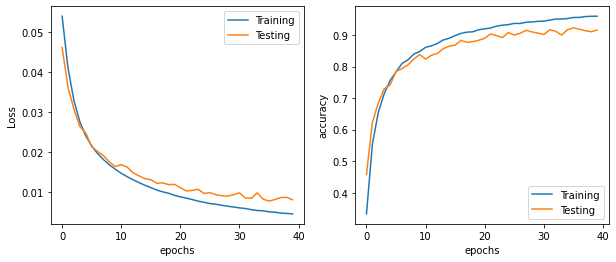

In [41]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_MLP_daisy.history['loss'],label='Training')
plt.plot(history_MLP_daisy.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_MLP_daisy.history['accuracy'],label='Training')
plt.plot(history_MLP_daisy.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

**Let's compare the performance.**

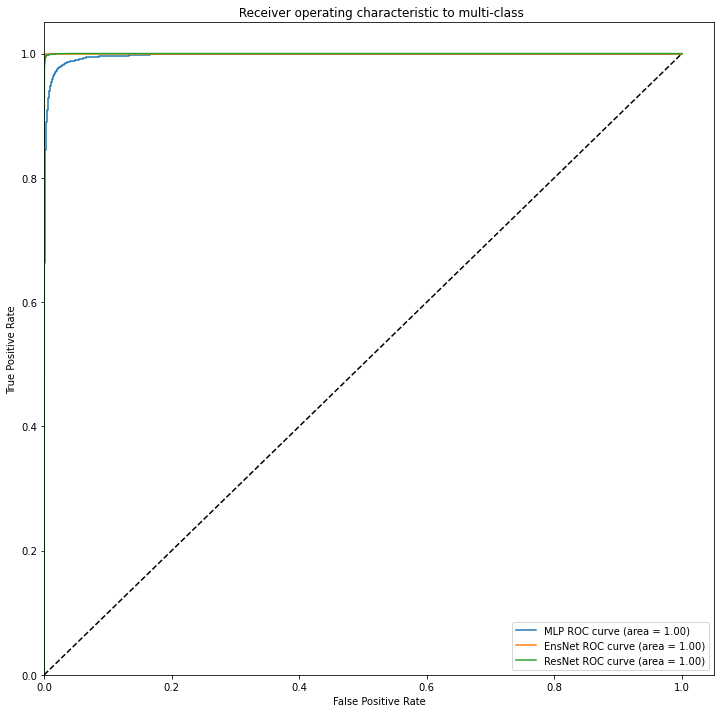

In [42]:
# Compute ROC curve and ROC area for each class

def roc(y_score):
    n_classes =15
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr,tpr,roc_auc

mlp_fpr,mlp_tpr,mlp_roc_auc=roc(mlp_daisy.predict_proba(X_test_daisy))
EnsNet_fpr,EnsNet_tpr,EnsNet_roc_auc=roc(EnsNet_2.predict(X_test))
ResNet_fpr,ResNet_tpr,ResNet_roc_auc=roc(ResNet_2.predict(X_test))
# Plot ROC curve
plt.figure(figsize=(12, 12))
plt.plot(mlp_fpr["micro"], mlp_tpr["micro"],
label='MLP ROC curve (area = {0:0.2f})'
               ''.format(mlp_roc_auc["micro"]))

plt.plot(EnsNet_fpr["micro"], EnsNet_tpr["micro"],
label='EnsNet ROC curve (area = {0:0.2f})'
               ''.format(EnsNet_roc_auc["micro"]))
plt.plot(ResNet_fpr["micro"], ResNet_tpr["micro"],
label='ResNet ROC curve (area = {0:0.2f})'
               ''.format(ResNet_roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**EnsNet and ResNet model are perfect, MLP model is almost perfect, it seems this data set is too easy.**

In [43]:
yhat_MLP = np.argmax(mlp_daisy.predict(X_test_daisy), axis=1)
print("MLP_DAISY vs EnsNet_2: Test statistic",mn_test(yhat_MLP, yhat_EnsNet_2, y_ori[test_idx_list[0]]))

MLP_DAISY  vs EnsNet_2: Test statistic 257.4031


**$\chi^2$ value for MLP_DAISY  vs EnsNet_2 is larger than 6.635, we can conclude that EnsNet_2 is better than MLP with 99% confidence.**

## 3. Transfer learning

In [44]:
# only need to change X to 3 channels
# use the preprocessed y

X_list_tl = []
for file in image_files:
    code = int(file.split('.jpg')[0].split('_')[-1])
    img_path = 'data/image/' + file
    img = cv2.imread(img_path)
    X_list_tl.append(img)
    # ResNet requires: exactly 3 inputs channels, and width and height no smaller than 32.
    # valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)
    # didn't zero mean, because of the requirement of VGG19

X_tl = np.array(X_list_tl)
print(X_tl[0].shape)

(64, 64, 3)


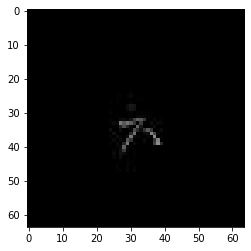

In [45]:
plt.imshow(X_tl[0])
plt.show()

In [46]:
# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))

In [47]:
X_train_tl = X_tl[train_idx_list[0]]
X_test_tl = X_tl[test_idx_list[0]]

In [48]:
x_train_up = preprocess_input(X_train_tl)
x_test_up = preprocess_input(X_test_tl)

In [49]:
%%time

x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)

(11250, 2, 2, 2048)
CPU times: user 7min 42s, sys: 39 s, total: 8min 21s
Wall time: 25.4 s


In [50]:
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(2000, activation='relu',kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

ResNet_tl = Model(inputs=input_x, outputs=predictions, name='ResNet_tl')

ResNet_tl.summary()

Model: "ResNet_tl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2, 2, 2048)]      0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 2000)              16386000  
_________________________________________________________________
dropout_19 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 200)               400200    
_________________________________________________________________
dense_38 (Dense)             (None, 15)                3015      
Total params: 16,789,215
Trainable params: 16,789,215
Non-trainable params: 0
_____________________________________________

In [51]:
ResNet_tl.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy']
                 )

In [52]:
%%time

history_ResNet_tl = ResNet_tl.fit(x_train_resnet, y_train, epochs=30, batch_size=64,
                                  verbose=1, validation_data=(x_test_resnet,y_test),
                                  callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                 )

Epoch 1/30
176/176 [==============================] - 8s 41ms/step - loss: 4.1200 - accuracy: 0.5387 - val_loss: 0.4340 - val_accuracy: 0.8368
Epoch 2/30
176/176 [==============================] - 7s 41ms/step - loss: 0.5373 - accuracy: 0.8172 - val_loss: 0.2621 - val_accuracy: 0.9112
Epoch 3/30
176/176 [==============================] - 7s 41ms/step - loss: 0.3986 - accuracy: 0.8706 - val_loss: 0.2560 - val_accuracy: 0.9016
Epoch 4/30
176/176 [==============================] - 7s 41ms/step - loss: 0.2988 - accuracy: 0.9001 - val_loss: 0.2370 - val_accuracy: 0.9208
Epoch 5/30
176/176 [==============================] - 7s 41ms/step - loss: 0.2875 - accuracy: 0.9146 - val_loss: 0.1987 - val_accuracy: 0.9288
Epoch 6/30
176/176 [==============================] - 7s 41ms/step - loss: 0.2541 - accuracy: 0.9206 - val_loss: 0.1826 - val_accuracy: 0.9387
Epoch 7/30
176/176 [==============================] - 7s 41ms/step - loss: 0.2524 - accuracy: 0.9232 - val_loss: 0.2358 - val_accuracy: 0.9141

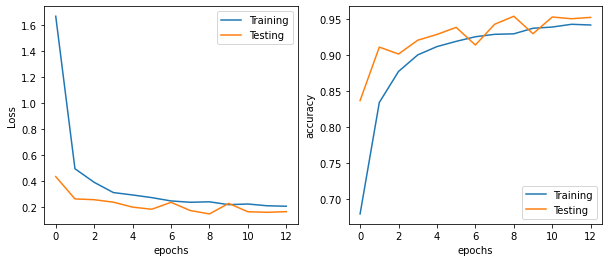

In [53]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ResNet_tl.history['loss'],label='Training')
plt.plot(history_ResNet_tl.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ResNet_tl.history['accuracy'],label='Training')
plt.plot(history_ResNet_tl.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [54]:
# compare ensnet_2 and resnet_tl
yhat_ResNet_tl = np.argmax(ResNet_tl.predict(x_test_resnet), axis=1)
print("ResNet_tl vs EnsNet_2: Test statistic",mn_test(yhat_ResNet_tl, yhat_EnsNet_2, y_ori[test_idx_list[0]]))

ResNet_tl  vs EnsNet_2: Test statistic 118.0904


**$\chi^2$ value for ResNet_tl  vs EnsNet_2 is larger than 6.635, we can conclude that EnsNet_2 is better than ResNet_tl with 99% confidence. Probably this data set is easy enough to predict then we don't fully utilize transfer learning. But still we need to notice, the training convergence time is much smaller for transfer learning `ResNet_tl` compared to `EnsNet_2`, and this is another advantage.**

## 4. Further thoughts

Here's some thoughts for this lab:
* When we are comparing and selecting models, we use the cross validation strategies. Here, in order to save time, we only used the first fold.
* In real world applications, normally we don't see the test data. Here we used this testing data as the validation in model training, but this is inappropriate. We should split the data into training data, validation data and test data. We use training data and validation data in the model fitting, then use testing data to compare models.
* For data with MNIST form, fully flattened MLP should have a respectively good performance, but here it fails. PCA and DAISY were used here as a compensation.